#  ATOC5860 Application Lab #3 - eigenfaces
##### Written by Dr. Vineel Yettella (ATOC Ph.D. 2018, now at Apple), with additional commenting from Prof. Kay (CU)
##### last updated February 22, 2023 - works with environment atoc5860env2023clean.yml

### LEARNING GOALS:
1) Complete an EOF analysis using Singular Value Decomposition (SVD). 
2) Provide a qualitative description of the results. What are the eigenvalues, the eigenvectors, and the principal components?  What do you learn from each one about the space-time structure of your underlying dataset?
3) Provide a qualitative description of the results: What are the eigenvalue,the eigenvector, and the principal component?  What do they mean physically? What do you learn from each one about the space-time structure of the underlying dataset?
4) Reconstruct original data using a subset of EOFs: How many EOFs are needed to reconstruct faces?

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you apply EOF analysis to a standard database for facial recognition: the At&t database. 

*“Our Database of Faces, (formerly 'The ORL Database of Faces'), contains a set of face images taken between April 1992 and April 1994 at the lab. The database was used in the context of a face recognition project carried out in collaboration with the Speech, Vision and Robotics Group of the Cambridge University Engineering Department.

There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).”*

The goal is to think a bit “out of the box” of Atmospheric and Oceanic Sciences about potential applications for the methods you are learning in this class.  And also to think about some of the pitfalls of using statistics for facial recognition. Are the faces here representative of all faces?

### Non-exhaustive Questions to guide your analysis:  
1) Execute all code without making any modifications. What do the EOFs (spatial patterns) tell you?  What do the PCs tell you?  How do you interpret what you are finding?

2) Reconstruct a face.  How many EOFs do you need to reconstruct a face from the database?  Does it depend on the face that it used?

3) Food for thought: The database contains 75% white men.  How do you think this database sampling limitation impacts the utility of the database for subjects who are not white men?  What are some parallels that you might draw when analyzing atmospheric and oceanic sciences datasets?  Hint: Think about the limitations of extrapolation beyond the domain where you have data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp 
from jax import random, jit
from sklearn.decomposition import PCA
import time
import bisect
%matplotlib inline

In [2]:
#load faces. Adapted from the AT&T face database
att_faces = np.load('att_faces.npy')
height, width, n_faces = att_faces.shape
print((height, width, n_faces))

(112, 92, 400)


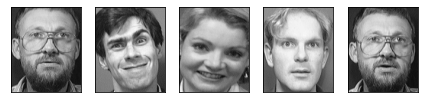

In [3]:
#print a few faces from the database - Look at your data!!
n = 5
fig, axs = plt.subplots(1, n)

random_face_inds = np.random.choice(np.arange(n_faces), n, replace=False)
for i, ax in enumerate(axs):
    ax.imshow(att_faces[:, :, random_face_inds[i]], cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()

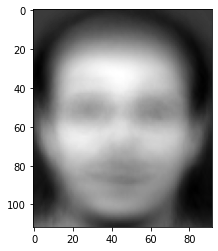

In [4]:
#print the average face
average_face = np.mean(att_faces, axis = 2);
plt.imshow(average_face, cmap = 'gray');

In [5]:
start = time.time()
#Construct the data matrix. Samples (different faces) along rows and 
#variables (individual pixels) along columns
print(att_faces.shape)
data_matrix = np.reshape(att_faces, (height*width, n_faces)).T
print('data matrix shape:', data_matrix.shape)

#Construct anomaly matrix by removing the average face, i.e., 
#by removing the column means from each column of the data_matrix
anomaly_matrix = data_matrix - np.mean(data_matrix, axis=0)
#anomaly_matrix = anomaly_matrix/np.std(anomaly_matrix, axis=0)
print('anomaly_matrix shape:', anomaly_matrix.shape)
[eofs, s, v] = np.linalg.svd(anomaly_matrix.T, full_matrices=False)

print('EOFs shape:', eofs.shape)

eigenvals = np.square(s)
variance_explained = eigenvals/np.sum(eigenvals)

print(f'Time used: {(time.time()-start):.2f} s')

(112, 92, 400)
data matrix shape: (400, 10304)
anomaly_matrix shape: (400, 10304)
EOFs shape: (10304, 400)
Time used: 0.41 s


In [6]:
"""
Use jax to increase the speed
"""
start = time.time()
#Construct the data matrix. Samples (different faces) along rows and 
#variables (individual pixels) along columns
print(att_faces.shape)
data_matrix = np.reshape(att_faces, (height*width, n_faces)).T
print('data matrix shape:', data_matrix.shape)

#Construct anomaly matrix by removing the average face, i.e., 
#by removing the column means from each column of the data_matrix
anomaly_matrix = data_matrix - np.mean(data_matrix, axis=0)
#anomaly_matrix = anomaly_matrix/np.std(anomaly_matrix, axis=0)
print('anomaly_matrix shape:', anomaly_matrix.shape)
[eofs, s, v] = jnp.linalg.svd(anomaly_matrix.T, full_matrices=False)

print('EOFs shape:', eofs.shape)

eigenvals = jnp.square(s)
variance_explained = eigenvals/jnp.sum(eigenvals)

print(f'Time used: {(time.time()-start):.2f} s')

(112, 92, 400)
data matrix shape: (400, 10304)
anomaly_matrix shape: (400, 10304)
EOFs shape: (10304, 400)
Time used: 0.30 s


In [7]:
### STEP 4 - Find the first two EOF patterns and PC timeseries 

# select an EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(eofs))
e1 = (v[eof_num-1,:])#.reshape(height, width)
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the SVD method
z1 = eofs[:,eof_num-1]  ###note: *(s[eof_num-1]) deleted
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# select an EOF
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the SVD method
e2 = (v[eof_num-1,:])#.reshape(height, width)
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the SVD method
z2 = eofs[:,eof_num-1] ###note: *(s[eof_num-1]) deleted
## standardize it
z2 = (z2-np.mean(z2))/np.std(z2)  
print(np.shape(z2))

(400, 400) (400,) (10304, 400)
(400,)
(10304,)
(400,)
(10304,)


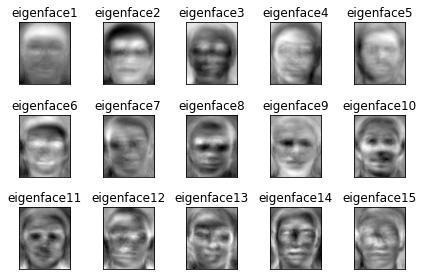

In [8]:
#Plot the top 15 eofs (a.k.a eigenfaces)

fig, axs = plt.subplots(3, 5)

for i, ax in enumerate(np.reshape(axs, 15)):
    eigenface = np.reshape(eofs[:, i], [height, width])
    ax.imshow(eigenface, cmap='gray')
    ax.set_title('eigenface' + str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout()

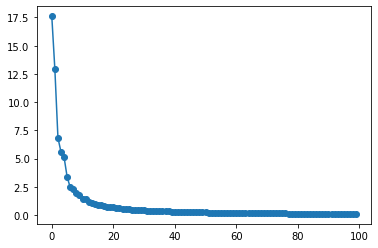

In [9]:
#Plot variance explained by each eigenface
plt.plot(variance_explained[0:100]*100, marker='o')

(400, 400)
(2,)
(6,)
(30,)
(111,)
(112, 92)


Text(0.5, 0.98, 'PCs explain')

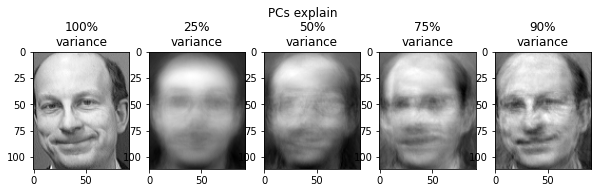

In [11]:
cumsum = np.cumsum(variance_explained)

#project the faces onto the eigenfaces
weights = np.dot(anomaly_matrix, eofs)
print(weights.shape)

#choose a face to reconstruct
face_num = 120 #0 to 389
original_face = att_faces[:, :, face_num]

#choose number of weights to reconstruct face
explain_25 = 0.25
weights_num = bisect.bisect(cumsum, explain_25)+1
face_weights = weights[face_num, 0:weights_num]
print(face_weights.shape)
reconstructed_face_25 = np.dot(eofs[:, 0:weights_num], face_weights)

explain_50 = 0.5
weights_num = bisect.bisect(cumsum, explain_50)+1
face_weights = weights[face_num, 0:weights_num]
print(face_weights.shape)
reconstructed_face_50 = np.dot(eofs[:, 0:weights_num], face_weights)


explain_75 = 0.75
weights_num = bisect.bisect(cumsum, explain_75)+1
face_weights = weights[face_num, 0:weights_num]
print(face_weights.shape)
reconstructed_face_75 = np.dot(eofs[:, 0:weights_num], face_weights)

explain_90 = 0.90
weights_num = bisect.bisect(cumsum, explain_90)+1
face_weights = weights[face_num, 0:weights_num]
print(face_weights.shape)
reconstructed_face_90 = np.dot(eofs[:, 0:weights_num], face_weights)

#At this point, the reconstructed face is an anomaly face with the average face removed. 
#Add back the average face to get the original face

reconstructed_face_25 = np.reshape(reconstructed_face_25, (height, width)) + average_face
reconstructed_face_50 = np.reshape(reconstructed_face_50, (height, width)) + average_face
reconstructed_face_75 = np.reshape(reconstructed_face_75, (height, width)) + average_face
reconstructed_face_90 = np.reshape(reconstructed_face_90, (height, width)) + average_face
print(reconstructed_face_25.shape)
fig, axs = plt.subplots(1, 5, figsize=(10,3))
axs[0].imshow(original_face, cmap='gray');
axs[0].set_title('100%\nvariance')
axs[1].imshow(reconstructed_face_25, cmap='gray');
axs[1].set_title('25%\nvariance')
axs[2].imshow(reconstructed_face_50, cmap='gray');
axs[2].set_title('50%\nvariance')
axs[3].imshow(reconstructed_face_75, cmap='gray');
axs[3].set_title('75%\nvariance')
axs[4].imshow(reconstructed_face_90, cmap='gray');
axs[4].set_title('90%\nvariance')
fig.suptitle('PCs explain')

(400, 10304)


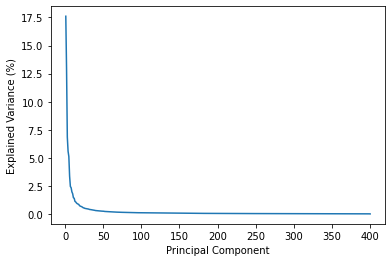

In [12]:
"""
Use pca from sklearn instead 
"""


X = anomaly_matrix
print(X.shape)

pca = PCA()#n_components = 3) 
X = pca.fit_transform(X)

explained_variance_ratio_ = pca.explained_variance_ratio_*100
#print(explained_variance_ratio_)
plt.plot(np.arange(len(explained_variance_ratio_))+1, explained_variance_ratio_)
plt.xlabel('Principal Component') 
plt.ylabel('Explained Variance (%)') 
plt.show()

In [13]:
pca.components_.shape

(400, 10304)